In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools
import photxspec

#### some useful functions

In [3]:
# conversions
# (need to define these first two functions for secondary axes with matplotlib)
def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift).value

def ell_to_k(ell, r_dist):
    return (ell + 0.5) / r_dist
def k_to_ell(k, r_dist):
    return (k * r_dist) - 0.5

In [4]:
# plot formatting
def grid(ax):
    ax.grid(lw=0.5, alpha=0.5)
    
def format_k(ax):
    ax.loglog()
    grid(ax)
    ax.set_xlabel(r'wavenumber $k$ (h/Mpc)')

def format_r(ax):
    ax.loglog()
    grid(ax)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    
def format_ell(ax):
    ax.loglog()
    grid(ax)
    ax.set_xlabel(r'$\ell$')

def format_theta(ax):
    ax.loglog()
    grid(ax)
    ax.set_xlabel(r'angular separation $\theta$ (deg)')

## covariance of the 3D 2pcf

Eq. 12 in Heitmann et al. (2021): https://ui.adsabs.harvard.edu/abs/2021ApJS..252...19H/abstract *

$$
C_\xi(r,r')=\int\frac{k^2\mathrm{d}k}{2\pi^2}j_0(kr)\,j_0(kr')\,\sigma^2_P(k) ~,
$$

where $\sigma_P$ is the shot noise component:
$$
\sigma^2_P = \frac{2}{V}\left(P(k)+\frac{1}{\bar n}\right)^2 ~,
$$
$P(k)$ is the galaxy power spectrum, $V$ is the simulation volume, and $\bar n$ is the mean tracer number density.

If we only care about the variance (diagonal terms), then
$$
\sigma^2(r) = \int\frac{k^2\mathrm{d}k}{2\pi^2}j_0^2(kr)\,\sigma^2_P(k)
$$

Then the standard deviation is just $\sigma(r)=\sqrt{\sigma^2(r)}$.

\* also cites Cohn (2006) and Smith et al. (2008)

In [5]:
# initialize simulation
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)

In [6]:
# comoving distance to the box center
r_dist = tools.redshift_to_comov(sim.redshift)
r_dist

<Quantity 1317.92319893 Mpc / littleh>

In [7]:
# construct spectroscopic sample
sigma_z = 0.01  # pick a reasonable redshift error from SPHEREx
# load subhalo positions from TNG and take the ones that we want for SPHEREx
#   (the indices gal_idx for SPHEREx are a function of redshift error and the target number density
#    at this redshift; the first argument is for the type of tracer (e.g. LRG), which isn't used for SPHEREx)
gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
gal_pos_spec -= sim.boxsize / 2  # shift positions to center at zero
assert np.all(np.abs(gal_pos_spec) < sim.boxsize/2)

 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294


Text(0.5, 1.0, 'SPHEREx spectroscopic sample, \n$z=$0.5, $\\sigma_z =$0.01: $n=$2.82e-03 (h/Mpc)$^3$')

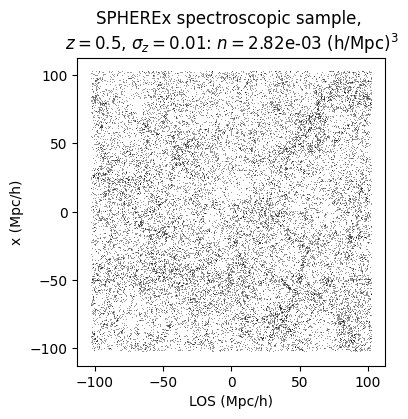

In [8]:
# plot the spectroscopic sample, projected to 2D: define the z coordinate ([:,2]) as the LOS
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(gal_pos_spec[:,2].value, gal_pos_spec[:,0].value, marker=',', ls='None', c='k', alpha=0.4)
ax.set_aspect('equal')
ax.set_xlabel('LOS (Mpc/h)')
ax.set_ylabel('x (Mpc/h)')
ax.set_title('SPHEREx spectroscopic sample, \n'r'$z=$'f'{sim.redshift:.1f}, 'r'$\sigma_z =$'f'{sigma_z:.2f}: 'r'$n=$'f'{sim.n.value:.2e} (h/Mpc)'r'$^3$')

#### inputs for the 3D variance calculation

In [9]:
# define k and r
k = np.logspace(-3, 2, 1000) << 1/r_dist.unit

# for r we need bin edges for the correlation function estimator
r_edges = np.logspace(np.log10(0.1), np.log10(80.), 101) << r_dist.unit

### $\sigma_P$: clustering + shot noise term

#### bias of the sample: Gal x DM / linear

In [10]:
# load underlying dark matter positions
dm_pos = tools.get_subsample(sim.dm_pos(), nx=100)
# construct corresponding random set: same volume and number of particles, but unclustered
rand_pos = np.random.uniform(-sim.boxsize.value/2, sim.boxsize.value/2, (len(dm_pos),3)) << r_dist.unit

In [11]:
# compute the 3D cross-correlation of the spectroscopic and DM samples:

# shift all positions to 0-boxsize to meet Corrfunc input requirements
d1 = gal_pos_spec + sim.boxsize/2
d2 = dm_pos
r2 = rand_pos + sim.boxsize/2

# xi_cross() checks that inputs are formatted correctly and computes the 3D cross-corr given separation bins
ravg, xix_spec = corrfuncs.xi_cross(d1, d2, r2, r_edges, sim.boxsize)

In [12]:
# compare the simulation result to linear theory:

# linear cf from colossus: ravg is the bin centers
xi_lin = tools.linear_2pcf(sim.redshift, ravg)

# ratio between these two gives us the bias
ratio = xix_spec / xi_lin

In [13]:
# bounds to compute bias: we want a relatively flat range (determined after looking at plot below)
rbounds = [5,20] # lower bound as suggested by Yun-Ting (tried 2 Mpc/h first)

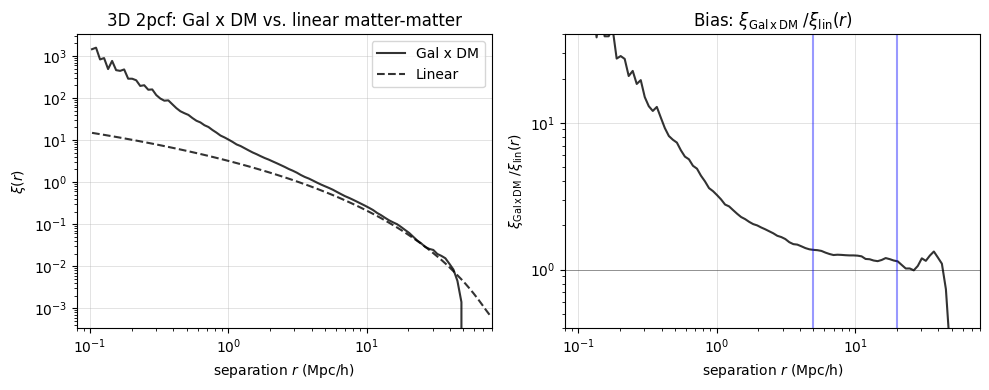

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].plot(ravg, xix_spec, 'k-', alpha=0.8, label='Gal x DM')
axs[0].plot(ravg, xi_lin, 'k--', alpha=0.8, label='Linear')
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('3D 2pcf: Gal x DM vs. linear matter-matter')
axs[0].legend()

axs[1].plot(ravg, ratio, 'k-', alpha=0.8)
axs[1].axhline(1., c='k', lw=0.5, alpha=0.5)
axs[1].axvline(rbounds[0], c='b', alpha=0.4)
axs[1].axvline(rbounds[1], c='b', alpha=0.4)
axs[1].set_ylim(0.4,40)
axs[1].set_ylabel(r'$\xi_\mathrm{Gal\, x\, DM}\ / \xi_\mathrm{lin}(r)$')
axs[1].set_title(r'Bias: $\xi_\mathrm{Gal\, x\, DM}\ / \xi_\mathrm{lin}(r)$')

for ax in axs:
    format_r(ax)
    ax.set_xlim(0.08, 80)
fig.tight_layout()

In [15]:
# bias = average of our chosen scale range
idx = (rbounds[0] <= ravg) & (ravg <= rbounds[1])
bias = np.mean(ratio[idx])
bias

1.2327234467436894

In [16]:
# define function to implement clustering and shot noise term from Heitmann equation, above
def compute_sigma_P_sq(k, bias, redshift, V, nbar, cosmo=cosmology.setCosmology('planck15'), runit=u.Mpc/u.littleh):
    # being extra careful with units:
    k = k.to(1/runit) if isinstance(k, u.Quantity) else k << 1/runit
    V = V.to(runit**3) if isinstance(V, u.Quantity) else V << runit**3
    nbar = nbar.to(runit**(-3)) if isinstance(nbar, u.Quantity) else nbar << runit**(-3)
    # matter power spectrum from Colossus
    P = cosmo.matterPowerSpectrum(k.value, sim.redshift) << runit**3
    
    return 2 / V * (bias**2 * P + 1 / nbar)**2

Text(0.5, 1.0, 'Matter power spectrum ($z=$0.5)')

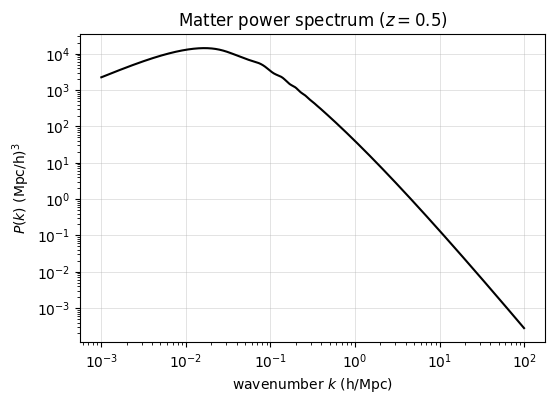

In [17]:
# check out the power spectrum
cosmo = cosmology.setCosmology('planck15')
P = cosmo.matterPowerSpectrum(k.value, sim.redshift) << r_dist.unit**3
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(k, P, 'k-')
format_k(ax)
ax.set_ylabel(r'$P(k)$ (Mpc/h)$^3$')
ax.set_title(r'Matter power spectrum ($z=$'f'{sim.redshift})')

In [18]:
# compute the clustering and shot noise term
sigma_P_sq = compute_sigma_P_sq(k=k, bias=bias, redshift=sim.redshift, V=sim.boxsize**3, nbar=sim.n)

Text(0.5, 1.0, '$\\sigma_P^2$: clustering + shot noise in 2pcf')

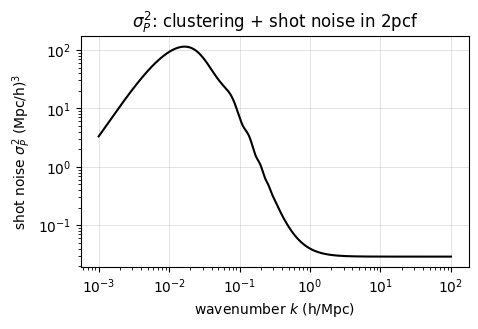

In [19]:
# plot to look at dependence on k
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(k, sigma_P_sq, 'k-')
format_k(ax)
ax.set_ylabel('shot noise $\sigma_P^2$ (Mpc/h)$^3$')
ax.set_title(r'$\sigma_P^2$: clustering + shot noise in 2pcf')

### integrate over $k$ to get $C_\xi(r,r')$

In [20]:
def var_3D(r, k, bias, sim):
    """
    Returns the variance of the auto 3D 2pcf at a single spatial separation r, by integrating over a range of
    wavenumbers k using Equation 12 in Heitmann et al. (2021).

    """
    
    assert r.size == bias.size == 1
    
    # multiplicative constant, outside the integral
    const = 1 / (2 * np.pi**2)

    # function of k that we want to integrate
    def integrand(k):
        return k**2 * special.spherical_jn(0, (k * r).value)**2 * \
                compute_sigma_P_sq(k, bias, sim.redshift, sim.boxsize**3, sim.n)

    # construct our array, integrand() at each input k
    k_func_arr = np.array([
        integrand(k_).value for k_ in k
    ]) << integrand(k[0]).unit  # shape (k,)
    
    # integrate using trapezoid rule
    trapz = integrate.trapz(k_func_arr, x=k)

    return const * trapz, k_func_arr  # also return the integrands for sanity checks

In [21]:
# calculate these variances for our range of r
pred_var_3D = np.empty(len(ravg))
k_arrs = np.empty((len(ravg),len(k)))
for i, r_ in enumerate(ravg):
    pred_var_3D[i], k_arrs[i] = var_3D(r_, k, bias, sim)

Text(0.5, 1.0, 'integrand: $f(k)=k^2\\, J_0(kr)^2\\, (2/V)\\,(P(k)+(1/\\bar n))^2$')

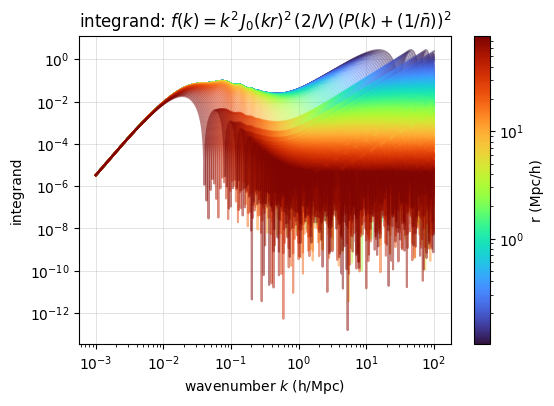

In [22]:
# plot to check: what do these integrands actually look like, and how do they evolve with r?
norm = mpl.colors.LogNorm(vmin=min(ravg), vmax=max(ravg))
smap = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
fig, ax = plt.subplots(figsize=(6,4))
for i, k_arr in enumerate(k_arrs):
    ax.plot(k, k_arr, alpha=0.5, c=smap.to_rgba(ravg[i]))
format_k(ax)
ax.set_ylabel('integrand')
fig.colorbar(smap, ax=ax, label=r'r (Mpc/h)')
ax.set_title(r'integrand: $f(k)=k^2\, J_0(kr)^2\, (2/V)\,(P(k)+(1/\bar n))^2$')

Text(0.5, 1.0, 'Predicted 2pcf uncertainty $\\sigma_\\xi(r)$')

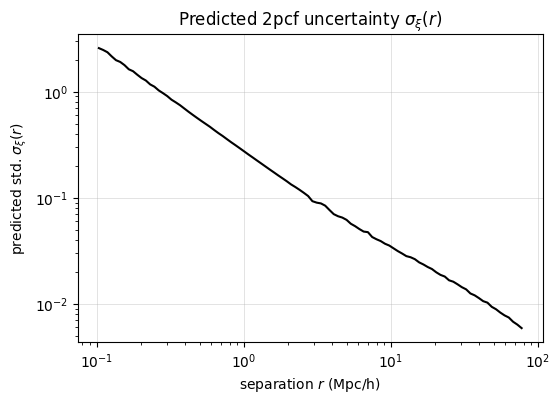

In [23]:
# plot predicted uncertainty in xi
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(ravg, np.sqrt(pred_var_3D), 'k-')
format_r(ax)
ax.set_ylabel(r'predicted std. $\sigma_\xi(r)$')
ax.set_title(r'Predicted 2pcf uncertainty $\sigma_\xi(r)$')

#### estimate $\xi(r)$ from pair counts, and compare to linear theory with error bars

In [24]:
# random set
r1 = np.random.uniform(0, sim.boxsize.value, (len(gal_pos_spec),3)) << r_dist.unit
# galaxy autocorrelation
ravg, xi_auto_spec = corrfuncs.xi_auto(d1, r1, r_edges << d1.unit, sim.boxsize)

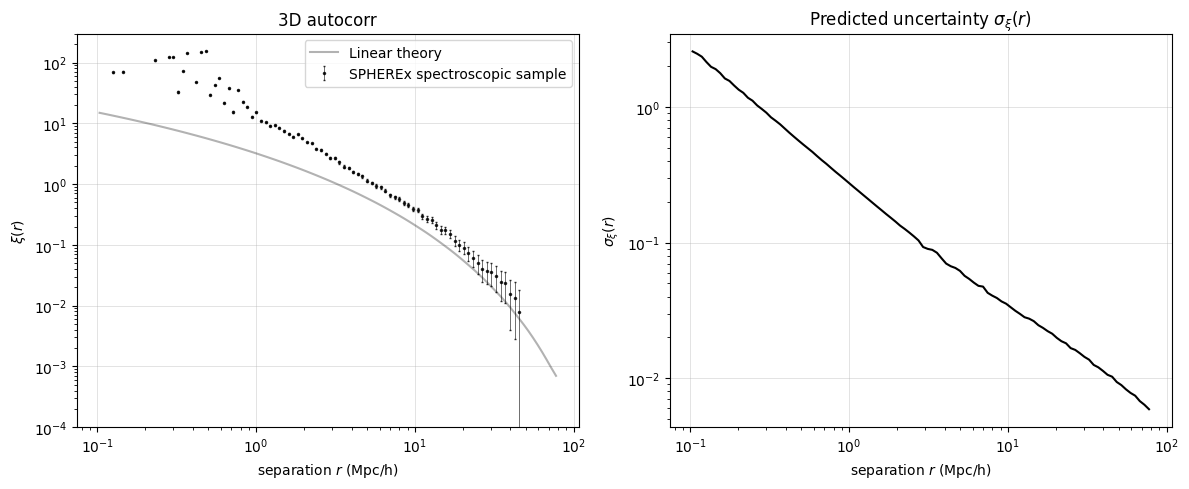

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))
idx = (xi_auto_spec > 1e-5)  # results at the smallest and largest scales return negative values; ignore these
axs[0].errorbar(ravg[idx], xi_auto_spec[idx], yerr=np.sqrt(pred_var_3D[idx]), c='k', marker='.',
                ls='None', ms=3, lw=0.5, capsize=1, alpha=0.8, label='SPHEREx spectroscopic sample')
axs[0].plot(ravg, xi_lin, c='k', alpha=0.3, label='Linear theory')
axs[0].set_ylim(1e-4,3e2)
axs[0].set_ylabel(r'$\xi(r)$')
axs[0].set_title('3D autocorr')
axs[0].legend()

axs[1].plot(ravg, np.sqrt(pred_var_3D), 'k-')
axs[1].set_ylabel(r'$\sigma_\xi(r)$')
axs[1].set_title(r'Predicted uncertainty $\sigma_\xi(r)$')

for ax in axs:
    format_r(ax)
fig.tight_layout()

## covariance of the angular 2pcf

From Adam, the covariance of the angular cross-correlation function is
$$
C_w(w_x(\theta),w_x(\theta'))=\frac{2}{\Omega_\mathrm{sim}}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\,\ell\,J_0(\ell\theta)\,J_0(\ell\theta')\,\frac{1}{2}[C_x^2(\ell) + C_a(\ell)C_b(\ell)] ~,
$$
where
- $a$ and $b$ are the respective samples (e.g. galaxies and dark matter)
- $\Omega_\mathrm{lim}$ is the area of the survey in steradians
- $J_0$ is a spherical Bessel function

If we only care about the variance (diagonal terms), then
\begin{align}
\sigma^2(\theta) &= \frac{2}{\Omega_\mathrm{sim}}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\,\ell\,J_0^2(\ell\theta)\,\frac{1}{2}\left[ C_x^2(\ell) + C_a(\ell)C_b(\ell)\right] \\
&= \frac{1}{2\pi\,\Omega_\mathrm{sim}}\int_0^\infty\mathrm{d}\ell\,\ell\,J_0^2(\ell\theta)\,\left[ \left[ C_x(\ell)+\frac{1}{\bar n_x}\right]^2 + \left[ C_a(\ell) + \frac{1}{\bar n_a}\right] \,\left[ C_b(\ell) + \frac{1}{\bar n_b}\right] \right]
\end{align}

where in the second line we've included contribution from shot noise, $\bar n\equiv N / \Omega_\mathrm{sim}$.

Analogously, for the auto angular 2pcf, the diagonal terms are
\begin{align}
\sigma^2(\theta) &= \frac{2}{\Omega_\mathrm{sim}}\int_0^\infty\frac{\mathrm{d}\ell}{2\pi}\,\ell\,J_0^2(\ell\theta)\,C^2(\ell) \\
&= \frac{1}{\pi\,\Omega_\mathrm{sim}}\int_0^\infty\mathrm{d}\ell\,\ell\,J_0^2(\ell\theta)\,\left[ C(\ell)+\frac{1}{\bar n}\right]^2
\end{align}

The approximation we have been using for the linear angular cross power spectrum $C_x(\ell)$, when we have photometric x spectroscopic samples, is
$$
C_x(\ell) \approx \frac{\Delta\chi}{\chi^2(\bar z)}\,W_\mathrm{phot}(\chi)\,W_i(\chi)\,b_\mathrm{phot}(\bar z)\,b_i(\bar z) \,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$
where
- $\chi$ is comoving distance to the box center
- $\bar z$ is the redshift of the snapshot
- $i$ indexes each slice along the LOS
- $\Delta\chi$ is the width of each slice
- $b$ is the bias of each sample
- $W_i$ are the spectroscopic weights, $W_i = \frac{1}{\Delta\chi}\quad \mathrm{if}\quad -\frac{\Delta\chi}{2}+\chi_i\leq\chi\leq\chi_i + \frac{\Delta\chi}{2}$
- $W_\mathrm{phot}$ are the photometric weights

Since here we only have a spectroscopic sample across the entire box, the expression can simplify to

$$
C(\ell) \approx \frac{1}{\chi^2(\bar z)\,\Delta\chi}\,b^2(\bar z)\,P_\mathrm{lin}\left(k=\frac{\ell + 1/2}{\chi(\bar z)},\bar z\right)
$$

where $\Delta\chi=L$, the boxsize.

### autocorrelation

#### compute the angular autocorrelation from simulation

In [26]:
# theta: we need bin edges for the Corrfunc estimator
theta_edges = np.logspace(np.log10(0.001), np.log10(5.), 21) << u.deg

# convert spectroscopic sample to 2D
ra_spec, dec_spec = tools.CartesiantoEquatorial(gal_pos_spec.value, observer=[0.,0.,r_dist.value])

# random set
ra_rand = np.random.uniform(min(ra_spec.value), max(ra_spec.value), len(ra_spec))
dec_rand = np.random.uniform(min(dec_spec.value), max(dec_spec.value), len(ra_spec))

# estimate correlation function
thetaavg, wtheta = corrfuncs.wtheta_auto(ra_spec.value, dec_spec.value, ra_rand, dec_rand, theta_edges.value)

### variance of the auto angular 2pcf

#### estimate $C(\ell)$

In [27]:
# compute Cell using the equation above:

# power spectrum from colossus
cosmo = cosmology.setCosmology('planck15')
P = cosmo.matterPowerSpectrum(k.value, sim.redshift) << r_dist.unit**3

# get ell from k
ell = k_to_ell(k, r_dist)

# Cell is a function of comoving distance to box center, boxsize, bias, and linear matter power spectrum
Cell = 1 / (r_dist**2 * sim.boxsize) * bias**2 * P

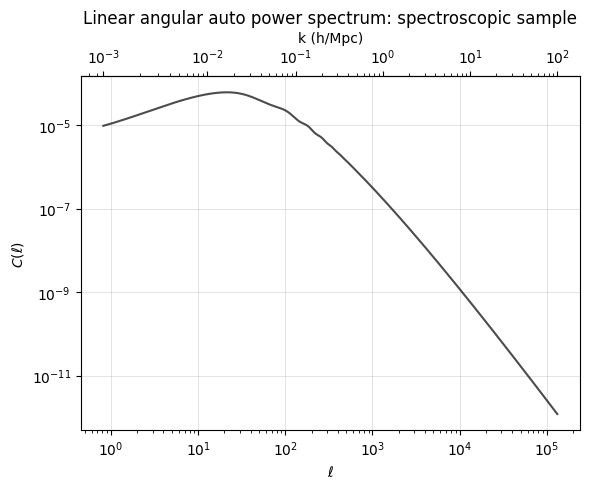

In [28]:
# plot the predicted Cell

# define functions to work with secondary axes in matplotlib
def ell_to_k_(ell):
    return (ell + 0.5) / r_dist.value
def k_to_ell_(k):
    return (k * r_dist.value) - 0.5

fig, ax = plt.subplots(figsize=(6,5))
ax.plot(ell, Cell, 'k-', alpha=0.7)
ax.loglog()
ax.grid(lw=0.5, alpha=0.5)
secax = ax.secondary_xaxis('top', functions=(ell_to_k_, k_to_ell_))
secax.set_xlabel('k (h/Mpc)')
ax.set_xlabel(r'$\ell$')
ax.set_ylabel(r'$C(\ell)$')
ax.set_title('Linear angular auto power spectrum: spectroscopic sample')
fig.tight_layout()

In [29]:
def var_2D_auto(theta, ell, Cell, Omega, nbar):
    """
    Returns the variance of the auto angular 2pcf at a single angular separation theta, by integrating
    over a range of wavenumbers ell.
    
    """
    
    assert theta.size == 1
    assert ell.ndim == Cell.ndim == 1
    assert len(ell) == len(Cell)
    
    theta = theta.to(u.rad).value if isinstance(theta, u.Quantity) else theta
    Omega = Omega.to(u.steradian).value if isinstance(Omega, u.Quantity) else (Omega << u.steradian).value
    nbar = nbar.to(1/u.steradian).value if isinstance(nbar, u.Quantity) else (nbar << 1/u.steradian).value
    
    # multiplicative constant, outside the integral
    const = 1 / (np.pi * Omega)
    
    # function of C(ell) that we want to integrate
    def integrand(ell_, Cell_): # ell and Cell are scalars
        return ell_ * special.jv(0, ell_ * theta)**2 * (Cell_ + 1 / nbar)**2
    
    # construct our array, and integrate using trapezoid rule
    ell_func_arr = np.array([
        integrand(ell[i], Cell[i]) for i in range(len(ell))
    ])
    assert ell_func_arr.shape == (len(ell),)
    trapz = integrate.trapz(ell_func_arr, x=ell)

    return const * trapz, ell_func_arr  # again, return the integrands to check

In [30]:
# define remaining inputs for var_2D_auto():

# Omega: area of the simulation in steradians
Omega = (tools.r_comov_to_theta(sim.boxsize, sim.redshift)**2).to(u.sr)

# nbar: number density of the simulation in steradians^{-1}
nbar = len(gal_pos_spec) / Omega
print(f"Omega = {Omega:.4f}\nnbar = {nbar:.2f}")

Omega = 0.0242 sr
nbar = 1004087.38 1 / sr


In [31]:
# calculate these variances for our range of theta
pred_var_2D = np.empty(len(thetaavg))
ell_arrs = np.empty((len(thetaavg),len(ell)))
for i, theta_ in enumerate(thetaavg << u.deg):
    pred_var_2D[i], ell_arrs[i] = var_2D_auto(theta_, ell, Cell, Omega, nbar)

Text(0.5, 1.0, 'integrand: $f(\\ell)=\\ell\\, J_0^2(\\ell\\theta)\\, [C(\\ell) + 1/\\bar n]^2$')

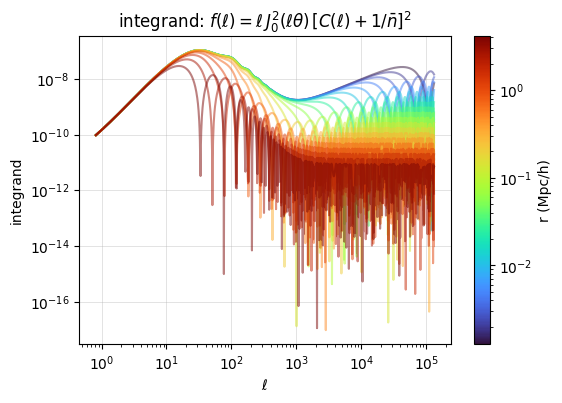

In [32]:
# plot to check: what do these integrands actually look like, and how do they evolve with r?
norm = mpl.colors.LogNorm(vmin=min(thetaavg), vmax=max(thetaavg))
smap = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
fig, ax = plt.subplots(figsize=(6,4))
for i, ell_arr in enumerate(ell_arrs):
    ax.plot(ell, ell_arr, alpha=0.5, c=smap.to_rgba(thetaavg[i]))
format_ell(ax)
ax.set_ylabel('integrand')
fig.colorbar(smap, ax=ax, label=r'r (Mpc/h)')
ax.set_title(r'integrand: $f(\ell)=\ell\, J_0^2(\ell\theta)\, [C(\ell) + 1/\bar n]^2$')

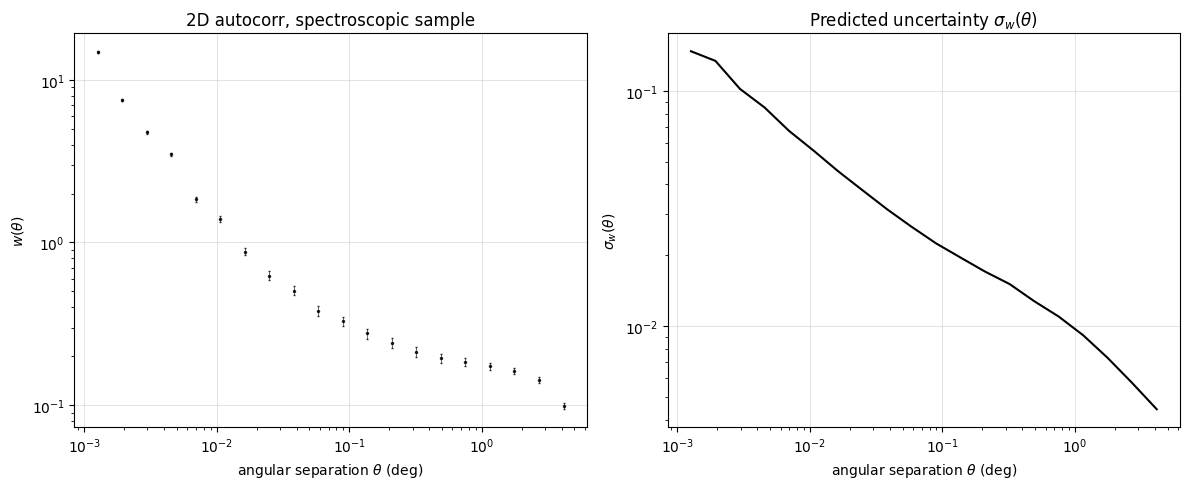

In [33]:
# plot the estimated 2D autocorr with errorbars
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].errorbar(thetaavg, wtheta, yerr=np.sqrt(pred_var_2D), c='k', marker='.', ls='None', ms=3, lw=0.5, capsize=1, alpha=0.8)
axs[0].set_ylabel(r'$w(\theta)$')
axs[0].set_title('2D autocorr, spectroscopic sample')

axs[1].plot(thetaavg, np.sqrt(pred_var_2D), 'k-')
axs[1].set_ylabel(r'$\sigma_w(\theta)$')
axs[1].set_title(r'Predicted uncertainty $\sigma_w(\theta)$')

for ax in axs:
    format_theta(ax)
fig.tight_layout()

### cross-correlation

#### compute the angular cross-correlation $w_x(\theta)$ from simulation

In [34]:
# line-of-sight bins
losbins = np.linspace(-sim.boxsize/2, sim.boxsize/2, 11)

In [35]:
# compute angular cross-correlation:
#   this also returns the photometric/spectroscopic samples (multiple because we shift around the box
#   to reduce noise) and other info
wtheta_cross_res = photxspec.compute_photxspec(gal_pos_spec, sim.redshift, sigma_z, sim.boxsize,
                                               losbins, theta_edges)
xcorrs = wtheta_cross_res['xcorrs']
slice_centers = wtheta_cross_res['slice_centers']

### variance of the cross angular 2pcf

#### estimate $C(\ell)$

In [36]:
# auto Cells: identical for the photometric and spectroscopic, since the former is drawn from the latter

# power spectrum from colossus
cosmo = cosmology.setCosmology('planck15')
P = cosmo.matterPowerSpectrum(k.value, sim.redshift) << r_dist.unit**3

# get ell from k
ell = k_to_ell(k, r_dist)

# Cell is a function of comoving distance to box center, boxsize, bias, and linear matter power spectrum
Cell = 1 / (r_dist**2 * sim.boxsize) * bias**2 * P

In [37]:
# cross Cell:

# take the first photometric realization
gal_pos_phot = wtheta_cross_res['gal_pos_phots'][0]

Cellx = photxspec.Cellx_theory(gal_pos_phot, gal_pos_spec, sim, thetaavg, losbins,
                                    ell=ell, r_edges=r_edges, b_spec=bias)

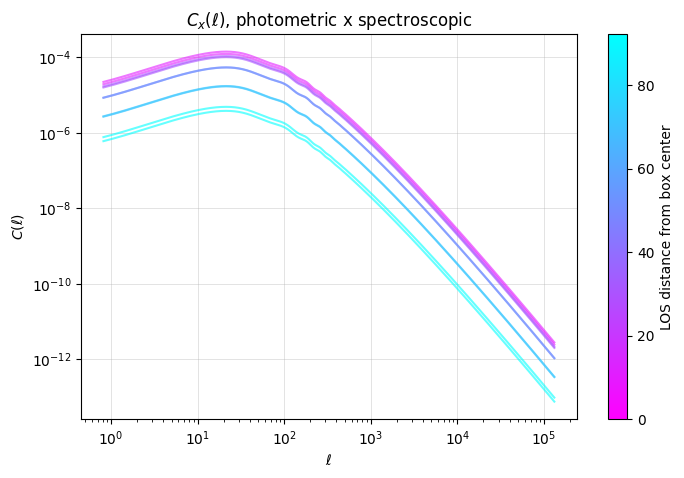

In [38]:
# plot the predicted angular cross power spectra in each slice along the LOS
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(8,5))
for i, Cell in enumerate(Cellx):
    kwargs = dict(c=smap.to_rgba(np.abs(slice_centers[i])))
    ax.plot(ell, Cell, alpha=0.6, **kwargs)
format_ell(ax)
ax.set_ylabel(r'$C(\ell)$')
ax.set_title(r'$C_x(\ell)$, photometric x spectroscopic')
fig.colorbar(smap, ax=ax, label='LOS distance from box center')

In [39]:
def var_2D_cross(theta, ell, Cell_x, Cell_a, Cell_b, Omega, nbar_x, nbar_a, nbar_b):
    """
    Returns the variance of the cross angular 2pcf at a single angular separation theta, by integrating
    over a range of wavenumbers ell.
    
    """
    
    assert theta.size == 1
    assert ell.ndim == Cell_x.ndim == Cell_a.ndim == Cell_b.ndim == 1
    assert len(ell) == len(Cell_x) == len(Cell_a) == len(Cell_b)
    
    theta = theta.to(u.rad).value if isinstance(theta, u.Quantity) else theta
    Omega = Omega.to(u.steradian).value if isinstance(Omega, u.Quantity) else (Omega << u.steradian).value
    nbar_x = nbar_x.to(1/u.steradian).value if isinstance(nbar_x, u.Quantity) else (nbar_x << 1/u.steradian).value
    nbar_a = nbar_a.to(1/u.steradian).value if isinstance(nbar_a, u.Quantity) else (nbar_a << 1/u.steradian).value
    nbar_b = nbar_b.to(1/u.steradian).value if isinstance(nbar_b, u.Quantity) else (nbar_b << 1/u.steradian).value
    
    # multiplicative constant, outside the integral
    const = 1 / (2 * np.pi * Omega)
    
    # function of C(ell) that we want to integrate
    def integrand(ell_, Cell_x_, Cell_a_, Cell_b_): # ell and Cell are scalars
        return ell_ * special.jv(0, ell_ * theta)**2 * \
                ((Cell_x_ + 1 / nbar_x)**2 + (Cell_a_ + 1 / nbar_a) * (Cell_b_ + 1 / nbar_b))
    
    # construct our array, and integrate using trapezoid rule
    ell_func_arr = np.array([
        integrand(ell[i], Cell_x[i], Cell_a[i], Cell_b[i]) for i in range(len(ell))
    ])
    assert ell_func_arr.shape == (len(ell),)
    trapz = integrate.trapz(ell_func_arr, x=ell)

    return const * trapz, ell_func_arr  # again, return the integrands to check

In [40]:
# define remaining inputs for var_2D_cross():

# Omega: area of the simulation
Omega = (tools.r_comov_to_theta(sim.boxsize, sim.redshift)**2).to(u.sr)

# nbar: number density of the simulation in steradians^{-1}
#  take the cross nbar to be the minimum number density between phot/spec
nbar_x = np.min([len(gal_pos_spec), len(gal_pos_phot)]) / Omega
nbar_a = len(gal_pos_phot) / Omega
nbar_b = len(gal_pos_spec) / Omega
print(f"Omega = {Omega:.4f}\nnbar_x = {nbar_x:.2f}\nnbar_a = {nbar_a:.2f}\nnbar_b = {nbar_b:.2f}")

Omega = 0.0242 sr
nbar_x = 413802.70 1 / sr
nbar_a = 413802.70 1 / sr
nbar_b = 1004087.38 1 / sr


In [41]:
# calculate these variances for our range of theta:
#   ! note different shape from the auto c.f. because we have multiple LOS slices now
pred_var_2D_x = np.empty((len(Cellx),len(thetaavg)))
ell_arrs_x = np.empty((len(Cellx),len(thetaavg),len(ell)))
for i, Cellx_ in enumerate(Cellx):
    for j, theta_ in enumerate(thetaavg << u.deg):
        pred_var_2D_x[i,j], ell_arrs_x[i,j] = var_2D_cross(theta_, ell, Cellx_, Cell, Cell,
                                                       Omega, nbar_x, nbar_a, nbar_b)

Text(0.5, 1.0, 'integrand: $f(\\ell)=\\ell\\, J_0^2(\\ell\\theta)\\, [[C_x(\\ell) + 1/\\bar n_x]^2 + (C_a(\\ell) + 1/\\bar n_a)\\,(C_b(\\ell) + 1/\\bar n_b)]$\n slice 5 of 10')

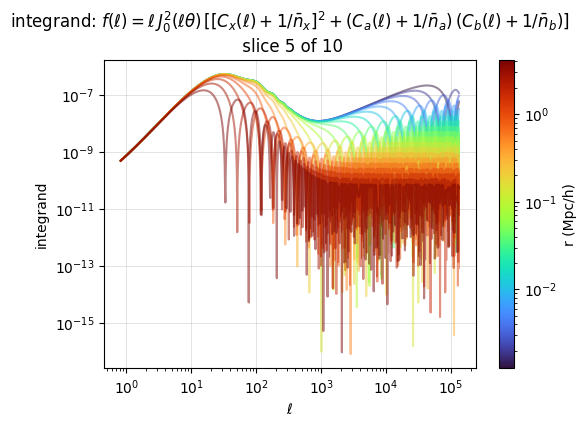

In [42]:
# plot to check: what do these integrands actually look like, and how do they evolve with r?
# pick a single photometric slice
islice = len(Cellx)//2
norm = mpl.colors.LogNorm(vmin=min(thetaavg), vmax=max(thetaavg))
smap = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
fig, ax = plt.subplots(figsize=(6,4))
for i, ell_arr in enumerate(ell_arrs_x[islice]):
    ax.plot(ell.value, ell_arr, alpha=0.5, c=smap.to_rgba(thetaavg[i]))
format_ell(ax)
ax.set_ylabel('integrand')
fig.colorbar(smap, ax=ax, label=r'r (Mpc/h)')
ax.set_title(r'integrand: $f(\ell)=\ell\, J_0^2(\ell\theta)\, ' +
             r'[[C_x(\ell) + 1/\bar n_x]^2 + (C_a(\ell) + 1/\bar n_a)\,(C_b(\ell) + 1/\bar n_b)]$' +
             f'\n slice {islice} of {len(Cellx)}')

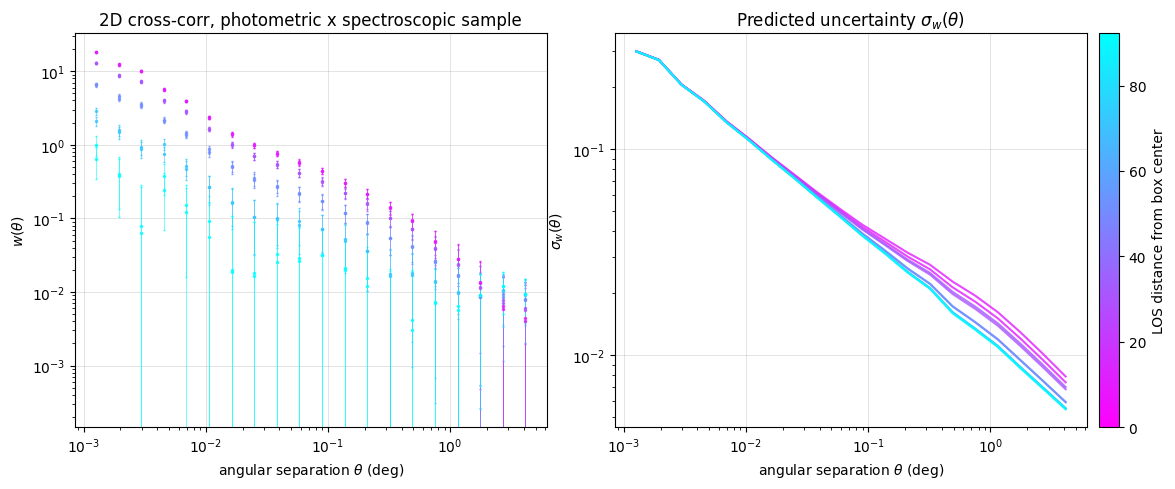

In [43]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')

fig, axs = plt.subplots(1, 2, figsize=(13,5))
for i, xcorr in enumerate(xcorrs):
    kwargs = dict(alpha=0.8, c=smap.to_rgba(np.abs(slice_centers[i])))
    axs[0].errorbar(thetaavg, xcorr, yerr=np.sqrt(pred_var_2D_x[i]), marker='.', ls='None', ms=3,
                    lw=0.5, capsize=1, **kwargs)
    axs[1].plot(thetaavg, np.sqrt(pred_var_2D_x[i]), ls='-', **kwargs)
axs[0].set_ylabel(r'$w(\theta)$')
axs[0].set_title('2D cross-corr, photometric x spectroscopic sample')

axs[1].set_ylabel(r'$\sigma_w(\theta)$')
axs[1].set_title(r'Predicted uncertainty $\sigma_w(\theta)$')

for ax in axs:
    format_theta(ax)
fig.tight_layout()
fig.colorbar(smap, ax=axs, label='LOS distance from box center', pad=0.01)

In [44]:
# compute cross-correlation predicted by linear theory:
wtheta_lins, Cells_ = photxspec.wlinx_theory(gal_pos_phot, gal_pos_spec, sim, thetaavg, losbins,
                                    ell=ell, r_edges=r_edges, b_spec=bias)

[]

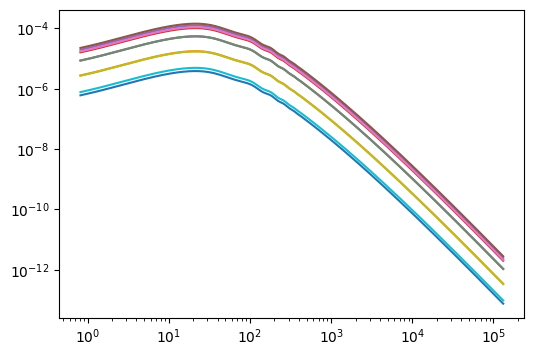

In [45]:
fig, ax = plt.subplots(figsize=(6,4))
for Cell_ in Cells_:
    ax.plot(ell, Cell_)
ax.loglog()

In [65]:
# integrate the power spectra to get the angular correlation function in each LOS bin
wlin_pred_ = np.empty(len(thetaavg))
ell_func_arrs = []
Cell = Cells_[0]
for i, theta_ in enumerate(thetaavg):
    theta = theta_.to(u.rad) if isinstance(theta_, u.Quantity) else theta_ << u.rad

    assert ell.ndim == Cell.ndim == 1, "input ell and Cell must be 1D"

    # function of ell that we want to integrate
    def integrand(ell_, Cell_):
        return (ell_ / (2 * np.pi)) * Cell_ * (special.jv(0, ell_ * theta.value))

    # construct our array, and integrate using trapezoid rule
    ell_func_arr = np.array([
        integrand(ell[i], Cell[i]) for i in range(len(ell))
    ])
    ell_func_arrs.append(ell_func_arr)
    trapz = integrate.trapz(ell_func_arr, x=ell)
    wlin_pred_[i] = trapz

[]

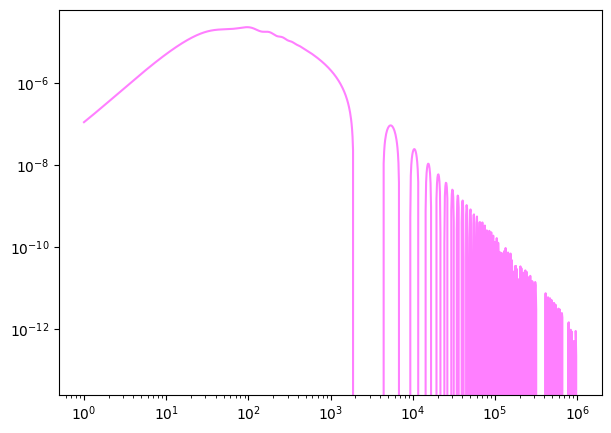

In [66]:
norm = mpl.colors.LogNorm(vmin=min(thetaavg), vmax=max(thetaavg))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool')
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(ell, ell_func_arrs[0], c=smap.to_rgba(thetaavg[i]), alpha=0.5)
ax.loglog()

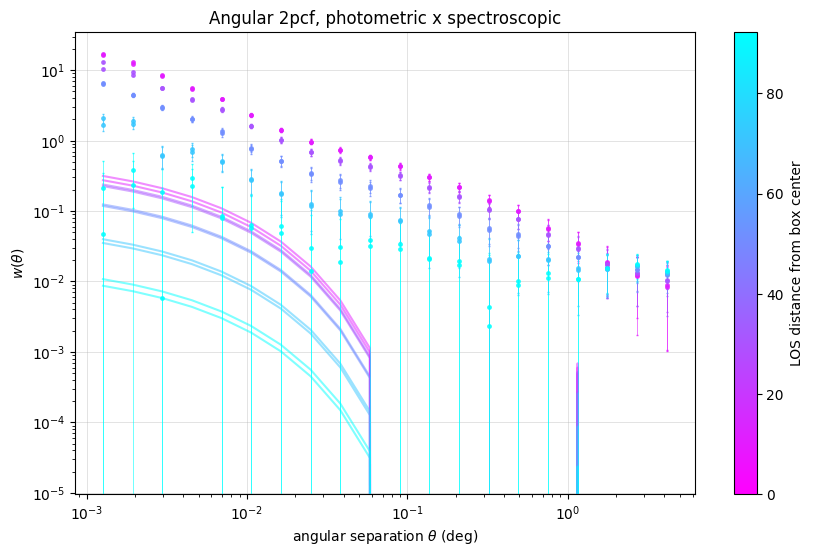

In [68]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig, ax = plt.subplots(figsize=(10,6))
for i, xcorr in enumerate(xcorrs):
    kwargs = dict(c=smap.to_rgba(np.abs(slice_centers[i])))
    labels = ['Estimator', 'Linear theory'] if i==len(xcorrs)//2 else ['','']
    ax.errorbar(thetaavg, xcorr, yerr=np.sqrt(pred_var_2D_x[i]), marker='.',
                ls='None', ms=5, alpha=0.8, capsize=1, lw=0.5, **kwargs)
    ax.plot(thetaavg, wtheta_lins[i], alpha=0.5, label=labels[1], **kwargs)
format_theta(ax)
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Angular 2pcf, photometric x spectroscopic')
fig.colorbar(smap, ax=ax, label='LOS distance from box center')

#### compare to linear theory